# The Ramachandran Plot for Alanine Dipeptide
The Ramachandran plot shows the values of the $\phi$ and $\psi$ dihedral angles of the peptide that correspond to accessible, low energy structures. In turn, these values give rise to the $\alpha$-helices and $\beta$-sheets protein structures. In this example, we will predict the Ramachandran plot for alanine dipeptide using conformation search techniques and molecular dynamics simulations. We will also illustrate the advantage of the Monte Carlo method for conformation search.

<img src="phi_psi.png" alt="drawing" width="400px"/>


## Monte Carlo Conformation Search
We will perform three kinds of conformation search:
- Systematic
- Random
- Monte Carlo

In the systematic search, we will build a complete picture of the potential energy surface of pentane along the two dihedral degrees of freedom ($\phi$ and $\psi$). We will construct a 181 by 181 grid of values (32,761 values) and calculate the energy at each ($\phi$, $\psi$) point. Then, we will construct the potential energy surface. We will use the AMBER ff14SB force field for calculating the energy. Systematic search is possible here because we only have two degrees of freedom. We will use the result to evaluate other search algorithms.

In the random search, we will start with some initial value of $\phi$ and $\psi$ and perform a certain number of iterations. At each step, we will increase or decrease the value of a randomly selected dihedral angle by a fixed amount. We will accept all the moves.

In the Monte Carlo search, we will start with the same initial value of $\phi$ and $\psi$. Then, we will perform a certain number of Monte Carlo iterations. At each step, we will increase or decrease the value of a randomly selected dihedral angle by a fixed amount. Then, unlike the random search procedure, we will accept or reject the move based on the Metropolis criteria. We will always accept the move if the energy of the system decreases. If the energy increases, we generate a random number between 0 and 1 and accept the move if $e^{-\Delta E/kT}$ is larger than the random number.

Below we show the geometry of alanine dipeptide:

In [1]:
# First display the geometry of alanine dipeptide
import numpy as np
from openbabel import openbabel as ob
import nglview as nv

conv = ob.OBConversion()
mol = ob.OBMol()
conv.ReadFile(mol, "alanine_dipeptide.pdb")
view = nv.show_openbabel(mol)
view.add_representation('label', labelType='serial', backgroundColor='black', showBackground=True)
view

NGLWidget()

### Systematic Search

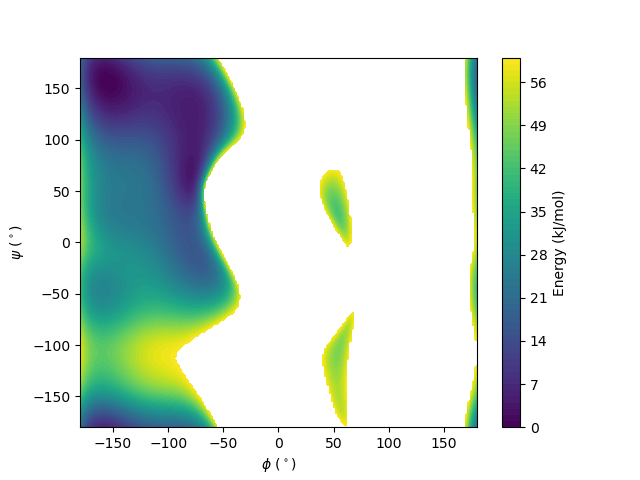

In [4]:
%matplotlib ipympl
from openmm.app import *
from openmm import *
from openmm.unit import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.close("all")

# Setup the simulation
temperature = 300 # Kelvin
pdb = PDBFile('alanine_dipeptide.pdb')
forcefield = ForceField("amber14/protein.ff14SB.xml")
system = forcefield.createSystem(pdb.topology, nonbondedMethod=NoCutoff)
integrator = LangevinMiddleIntegrator(1*kelvin, 1/picosecond, 1*femtoseconds)
platform = Platform.getPlatformByName('CPU')
simulation = Simulation(pdb.topology, system, integrator, platform)

# Perform the systematic search
torsions = [[5, 7, 9, 15], [7, 9, 15, 17]]


# Generate a mesh of grid points for the two dihedral angles
phi = np.linspace(-np.pi, np.pi, 181)
psi = np.linspace(-np.pi, np.pi, 181)

phi, psi = np.meshgrid(phi, psi)
energies = np.zeros_like(phi)

# Calculate the energy on the grid
for i in range(len(phi)):
    for j in range(len(psi)):
        mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], phi[i, j])
        mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], psi[i, j])
        positions = []
        for atom in ob.OBMolAtomIter(mol):
            positions.append(Vec3(atom.GetX(), atom.GetY(), atom.GetZ())*angstroms)
        simulation.context.setPositions(positions)
        energies[i, j] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(kilojoules/mole)
min_energy = np.min(energies)
energies -= min_energy

energies[energies>60] = np.nan
phi, psi = phi*180/np.pi, psi*180/np.pi
plt.figure()
fil = plt.contourf(phi, psi, energies, levels=60)
plt.colorbar(fil, label="Energy (kJ/mol)")

#plt.colorbar(im)
plt.xlabel(r'$\phi$ $(^\circ)$')
plt.ylabel(r'$\psi$ $(^\circ)$')

plt.show()

The above figure plots the relative energy of alanine dipeptide as a function of $\phi$ and $\psi$ (Energies above 60 kJ/mol are set to white to simplify plot). The plot agrees with what we expect for the Ramachandran plot. The left-hand region, which corresponds to the values required for forming $\alpha$-helices and $\beta$-sheets, is lower in energy.

Below we visualize some of the structures.

In [5]:
from IPython.display import display

mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], -160/180.0*np.pi)
mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], 160/180.0*np.pi)
view = nv.show_openbabel(mol)

print("phi=-160 and psi=160 degrees")
display(view)

mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], -80/180.0*np.pi)
mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], -30/180.0*np.pi)
view = nv.show_openbabel(mol)

print("phi=-80 and psi=-30 degrees")
display(view)

phi=-160 and psi=160 degrees


NGLWidget()

phi=-80 and psi=-30 degrees


NGLWidget()

## Random Search

Now we will explore the potential energy surface using the random search procedure. We will start from some randomly chosen initial structure. Then, at each step, we will select one dihedral angle and either increase it or decrease by $4^\circ$. 

The initial values: phi = -29.872078; psi = 79.316818 degrees


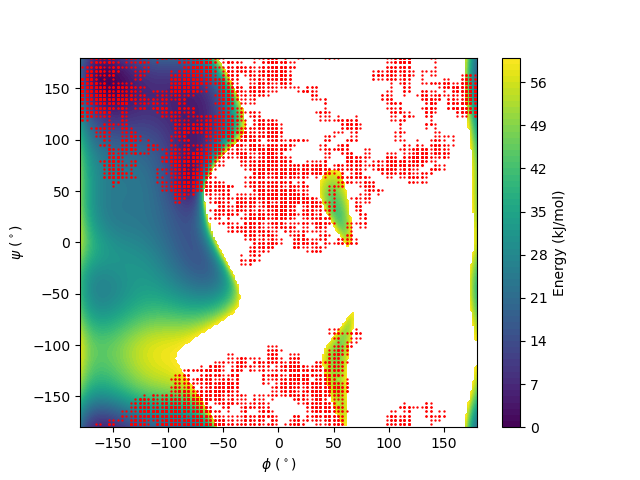

In [6]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0

# set random number seed
np.random.seed(1)

# Set initial torsions to some random values
initial_phi = np.random.uniform(-np.pi, np.pi)
initial_psi = np.random.uniform(-np.pi, np.pi)
mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], initial_phi)
mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], initial_psi)
print("The initial values: phi = %f; psi = %f degrees"
      %(initial_phi*180/np.pi, initial_psi*180/np.pi,))


# Perform a random conformation search
random_phi = []
random_psi = []

for i in range(niter):
    # Select a dihedral angle randomly
    index = np.random.choice([0, 1])
    # Get the current value for the dihedral angle
    previous_torsion = mol.GetTorsion(torsions[index][0], torsions[index][1],
                                      torsions[index][2], torsions[index][3])/180.0*np.pi
    # Randomly choose whether to increase or decrease the dihedral angle and update the angle
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(torsions[index][0], torsions[index][1], torsions[index][2], torsions[index][3], new_torsion)

    # Accept all moves
    random_phi.append(mol.GetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3]))
    random_psi.append(mol.GetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3]))

random_phi = np.array(random_phi)
random_psi = np.array(random_psi)

# Plot the results of the random search
plt.figure()
fil = plt.contourf(phi, psi, energies, levels=60)
plt.colorbar(fil, label="Energy (kJ/mol)")
plt.scatter(random_phi, random_psi, s=0.5, alpha=1, color="red")

#plt.colorbar(im)
plt.xlabel(r'$\phi$ $(^\circ)$')
plt.ylabel(r'$\psi$ $(^\circ)$')

plt.show()

We can notice that the random search procedure samples some low energy conformations. However, some steps are wasted in exploring very high energy structures. High energy structure contributes very little to the average properties of the molecules, as determined by the Boltzmann factor. Thus, some of the iterations are wasted and the conformation search is not very efficient.

**Starting from the *same* initial configuration, explore how the random number seed affects the conformation search procedure.**

Write your comments: ------

**Explore how starting from *different* initial configurations affect the conformation search procedure.**

Write your comments: ------

**Based on your above explorations, discuss why multiple replications are usually needed when using random numbers or running stochastic simulations.**

Write your comments: ------

**Comment on how the number of iterations affects the conformation search procedure.**

Write your comments: ------


## Monte Carlo Seach
We expect the Monte Carlo procedure to perform better than the random search procedure in the sense that it will sample the more important regions of the potential energy surface. The Metropolis criteria will also allow the exploration of higher regions of the phase space, so the system may be able to escape local minima.

The initial values: phi = -29.872078; psi = 79.316818 degrees


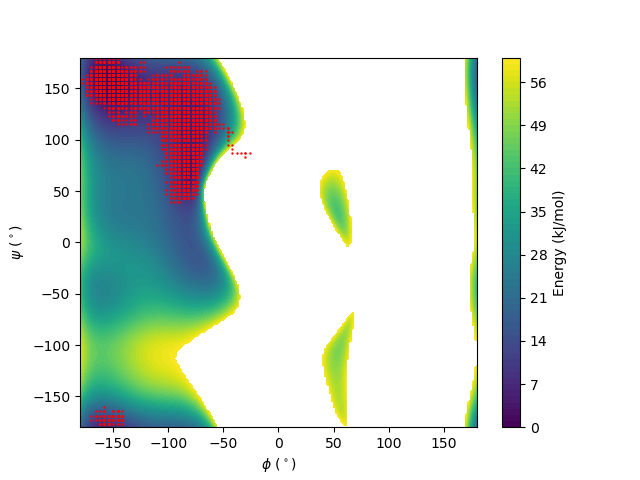

In [7]:
# Set the conformation search parameters
niter = 10000
step = np.pi/180.0*4.0
T = 300

k = 1.380658e-23
Na = 6.02214076e23 

# set random number seed
np.random.seed(1)
rng2 = np.random.default_rng(0) # Just for testing, we set a parallel generator. If T is very large, we recover random conformation search

# Set initial torsions to some random values
initial_phi = np.random.uniform(-np.pi, np.pi)
initial_psi = np.random.uniform(-np.pi, np.pi)
mol.SetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3], initial_phi)
mol.SetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3], initial_psi)
print("The initial values: phi = %f; psi = %f degrees"
      %(initial_phi*180/np.pi, initial_psi*180/np.pi,))

# Set up the force field and compute the initial energy
positions = []
for atom in ob.OBMolAtomIter(mol):
    positions.append(Vec3(atom.GetX(), atom.GetY(), atom.GetZ())*angstroms)
simulation.context.setPositions(positions)
previous_energy = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(joules/mole)

# Perform a Monte Carlo conformation search
mc_phi = []
mc_psi = []

for i in range(niter):
    # Select a dihedral angle randomly
    index = np.random.choice([0, 1])
    # Get the current value for the dihedral angle
    previous_torsion = mol.GetTorsion(torsions[index][0], torsions[index][1],
                                      torsions[index][2], torsions[index][3])/180.0*np.pi
    # Randomly choose whether to increase or decrease the dihedral angle and update the angle
    sign = np.random.choice([-1, 1])
    new_torsion = previous_torsion + sign * step
    mol.SetTorsion(torsions[index][0], torsions[index][1], torsions[index][2], torsions[index][3], new_torsion)
    
    # Calculate the energy of the new structure
    positions = []
    for atom in ob.OBMolAtomIter(mol):
        positions.append(Vec3(atom.GetX(), atom.GetY(), atom.GetZ())*angstroms)
    simulation.context.setPositions(positions)
    current_energy = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(joules/mole)
    
    # Test the Metropolis acceptance criteria
    delta_E = (current_energy-previous_energy)/Na
    if current_energy < previous_energy or np.exp(-delta_E/k/T) > rng2.random():
        # Store the dihedral angles and energies
        mc_phi.append(mol.GetTorsion(torsions[0][0], torsions[0][1], torsions[0][2], torsions[0][3]))
        mc_psi.append(mol.GetTorsion(torsions[1][0], torsions[1][1], torsions[1][2], torsions[1][3]))
        previous_energy = current_energy
    # If the move is not accepted, reset the value of the dihedral angle
    else:
        mol.SetTorsion(torsions[index][0], torsions[index][1], torsions[index][2],
                       torsions[index][3], previous_torsion)

mc_phi = np.array(mc_phi)
mc_psi = np.array(mc_psi)

# Plot the results of the Monte Carlo search
plt.figure()
fil = plt.contourf(phi, psi, energies, levels=60)
plt.colorbar(fil, label="Energy (kJ/mol)")
plt.scatter(mc_phi, mc_psi, s=0.5, alpha=1, color="red")

#plt.colorbar(im)
plt.xlabel(r'$\phi$ $(^\circ)$')
plt.ylabel(r'$\psi$ $(^\circ)$')

plt.show()

**Comment on the observed differences in the conformational sampling of the random and the Monte Carlo procedures.**

Write your comments: ------

**Explore the effect of the temperature on the acceptance and rejection of the moves.**

Write your comments: ------

## Molecular Dynamics Simulations of Solvated Alanine Dipeptide
Now, we will use molecular dynamics simulations to explore the structure of alanine dipeptide in water. 

### The Simulation Protocol
We will perform the simulation in three steps:
- Initial minimization to remove bad initial contacts.
- Run at constant temperature and volume (NVT) to reach the desired temperature.
- Run at constant pressure and temperature (NPT) to stabilize the density.

We will use the follownig simulation parameters:
- The TIP3P and ff14SB force fields.
- The particle mesh Ewald method for treating long-range interaction with periodic boundary conditions.
- 10 Angstrom cutoff distance for van der Waals interaction.
- The Langevin middle integrator with a temperature of 300 K, 1 ps$^{-1}$ friction coefficient, and 2 fs time step.
- The Monte Carlo barostat for controlling the pressure at 1 atm

We will store snapshots of the trajectory and some thermodynamic data every 1 ps.

In [8]:
# First display the water box
import nglview as nv
import mdtraj as md

system = md.load("system.pdb")
view = nv.show_mdtraj(system)
view.clear_representations()
view.add_representation("licorice")
view.parameters = {"cameraType": "orthographic"}
view.center()
view

NGLWidget()

In [23]:
# NO NEED TO RUN THIS
raise Exception # protects against accidental overwriting of trajectory
from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
temperature = 300 # Kelvin
pdb = PDBFile('system.pdb')
forcefield = ForceField("amber14/protein.ff14SB.xml", "amber14/tip3p.xml")
system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 2*femtoseconds)
platform = Platform.getPlatformByName('CUDA')
properties = {'Precision': 'mixed'}
simulation = Simulation(pdb.topology, system, integrator, platform, properties)
simulation.context.setPositions(pdb.positions)

# Minimize the structure
simulation.minimizeEnergy()

# Perform NVT simulation
simulation.reporters.append(DCDReporter('NVT.dcd', 500)) # Store trajectory using the dcd binary format
simulation.reporters.append(StateDataReporter("NVT.txt", 500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
simulation.step(5000)

# Add barostat
system.addForce(MonteCarloBarostat(1*atmosphere, temperature*kelvin))
state = simulation.context.getState(getPositions=True, getVelocities=True)
simulation.context.reinitialize()
simulation.context.setPositions(state.getPositions())
simulation.context.setVelocities(state.getVelocities())

# Perform NPT simulation
simulation.reporters[0] = DCDReporter('NPT.dcd', 500)
simulation.reporters[1] = StateDataReporter("NPT.txt", 500, time=True,
        potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
simulation.step(500000)

Having performed the simulation, the next step is visualization and analyzing the trajectory. We will first analyze the NVT simulation and then analyze the NPT simulation.

### Analysis of the NVT Simulation
Typically, an initial NVT simulation is performed even if NPT is the desired ensemble. This is done to stabilize the temperature first. We will first visualize the trajectory. Then, we will plot some thermodynamic parameters. We will make sure that the volume remains constant and the temperature reaches the target value of 300 K.

In [9]:
# Display the NVT trajectory
traj = md.load("NVT.dcd", top="system.pdb")
view = nv.show_mdtraj(traj)
view.clear_representations()
view.add_representation("licorice")
view.center()
view.parameters = {"cameraType": "orthographic"}
view

NGLWidget(max_frame=9)

The first frame looks surprising. Instead of having a single water box, we now have eight water boxes with some empty space in between! This is just a visualization artifact because we are using periodic boundary conditions. If we replicate this box along the three Cartesian coordinates, we will get multiple bigger boxes. This visualization issue sometimes confuse new practitioners of MD simulations.

As the simulation progresses, we see that the a very big empty space (a *bubble*) appears in the center. This happens because the initial box volume cannot be completely packed with water molecules. Because the volume is constant for NVT simulations, this void will not disappear but will coalesce in the middle. The following NPT simulation will adjust the box volume, causing the bubbles to disappear.

Now we will plot some thermodynamic parameters.

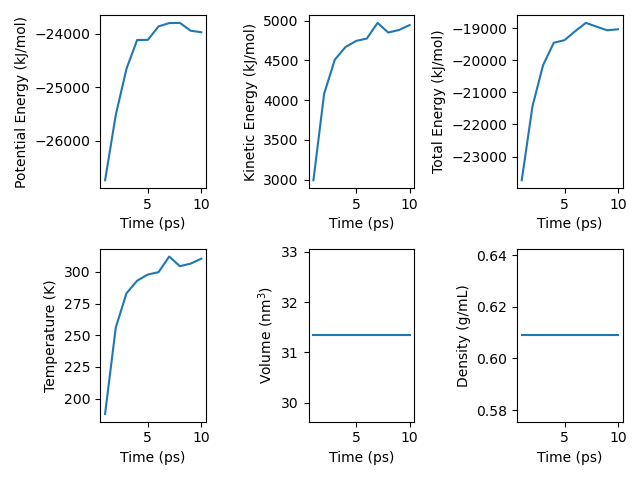

In [10]:
# Plot the thermodynamic data
import numpy as np
import matplotlib.pyplot as plt

nvt_data = np.loadtxt("NVT.txt", delimiter=",")
time = nvt_data[:, 0]
potential_energy = nvt_data[:, 1]
kinetic_energy = nvt_data[:, 2]
total_energy = potential_energy + kinetic_energy
temperature = nvt_data[:, 3]
volume = nvt_data[:, 4]
density = nvt_data[:, 5]

ylabels = [["Potential Energy (kJ/mol)", "Kinetic Energy (kJ/mol)", "Total Energy (kJ/mol)"],
           ["Temperature (K)", "Volume (nm$^3$)", "Density (g/mL)"]]
data = [[potential_energy, kinetic_energy, total_energy], [temperature, volume, density]]
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        axs[i, j].plot(time, data[i][j])
        axs[i, j].set_xlabel("Time (ps)")
        axs[i, j].set_ylabel(ylabels[i][j])

fig.tight_layout()
plt.show()

We can notice a few things. At the beginning of the simulation, the temperature is small, and so is the kinetic energy. As the system is heated, the temperature increases until we reach our target temperature of 300 K. Then, the energies and temperature fluctuate around a stable average value. Even though this is a constant temperature simulation, the temperature is not strictly constant but it is allowed to fluctuate. For NVT simulations, the volume is strictly constant, and it clear that it does not change overtime. Because both the volume and the number of particles (and mass) are constant, the density is also constant. However, the current density is very far from the expected density of water at 300 K and 1 atm ($\sim 1$ g/mL) because of the bubble in the box. By running NPT simulation, we can stabilize the density.

### Analysis of the NPT Simulation
Again, we will visualize the trajectory and then plot the same thermodynamic variables.

In [11]:
# Display the NPT trajectory
traj = md.load("NPT.dcd", top="system.pdb")
view = nv.show_mdtraj(traj)
view.clear_representations()
view.add_representation("licorice")
view.center()
view.parameters = {"cameraType": "orthographic"}
view

NGLWidget(max_frame=999)

In the NPT simulation, the volume of the box is allowed to change. The bubble gradually decreases in size until it disappears completely. In turn, the volume of the box also decreases and then becomes stable.

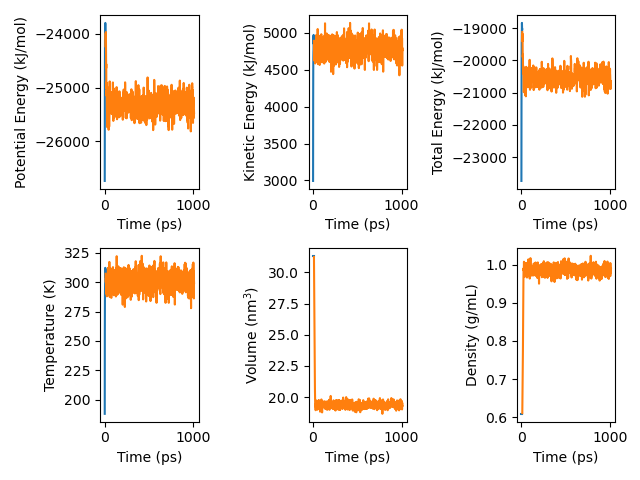

The average density is 0.986025.
The standard deviation of the density is 0.010292


In [12]:
import numpy as np
import matplotlib.pyplot as plt

npt_data = np.loadtxt("NPT.txt", delimiter=",")
npt_time = npt_data[:, 0] + time[-1] # add the final time from the NVT simulation
potential_energy = npt_data[:, 1]
kinetic_energy = npt_data[:, 2]
total_energy = potential_energy + kinetic_energy
temperature = npt_data[:, 3]
volume = npt_data[:, 4]
density = npt_data[:, 5]

npt_data = [[potential_energy, kinetic_energy, total_energy], [temperature, volume, density]]
fig, axs = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        # First plot NVT, then NPT data
        axs[i, j].plot(time, data[i][j])
        axs[i, j].plot(npt_time, npt_data[i][j])
        axs[i, j].set_xlabel("Time (ps)")
        axs[i, j].set_ylabel(ylabels[i][j])

fig.tight_layout()
plt.show()

# Calculate the average value of the density
density_avg = np.mean(density[len(density)//2:])
density_std = np.std(density[len(density)//2:])

print("The average density is %f." %(density_avg))
print("The standard deviation of the density is %f" %(density_std))

We notice that the temperature is still stable at the target temperature of 300 K, and the kinetic energy also remains stable. The potential energy improves as the molecules come closer until it reaches a stable value. This in turn affects the total energy. The volume decreases rapidly as pressure is applied and it reaches a stable value. Because the volume decreases, the density increases until it reaches the expected value of $\sim 1$ g/mL.

These plots show why we need equilibration and production stages. At the beginning of the NVT and NPT simulations, the thermodynamic parameters can change substantially before the system reaches a stable state. The initial parts of the MD trajectory should be discarded until the system reaches equilibrium.

### Ramachandran Plot
Now we will observe the conformations that alanine dipeptide adopts in solution. We will first visualize the motion of the peptide. Then, we will plot the Ramachandran plot in a 2-dimensional histogram, where the color indicates the frequency that the peptide adopts a given range of ($\phi$, $\psi$) values.

In [13]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
traj = md.load("NPT.dcd", top="system.pdb")
traj = traj[200:] # Exclude 200 frames of the trajectory for equilibration
traj = traj.superpose(traj, 0, atom_indices=range(22))
view = nv.show_mdtraj(traj)
view.center(selection="not water")
view.clear_representations()
view.add_representation("licorice", selection="not water")
view.parameters = {"cameraType": "orthographic"}
view

NGLWidget(max_frame=799)

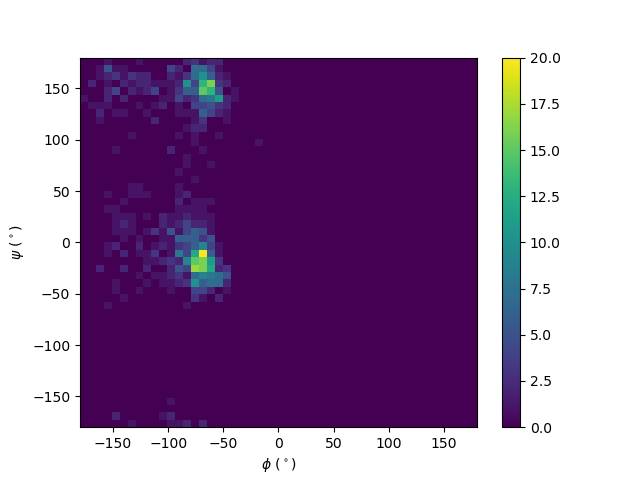

In [14]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
traj = md.load("NPT.dcd", top="system.pdb")
traj = traj[200:] # Exclude 200 frames of the trajectory for equilibration
phi = md.compute_phi(traj)[1]*180/np.pi
phi = np.squeeze(phi)
psi = md.compute_psi(traj)[1]*180/np.pi
psi = np.squeeze(psi)
plt.figure()
plt.hist2d(phi, psi, bins=(50, 50), range=((-180, 180), (-180, 180)))
plt.xlabel("$\phi$ $(^\circ)$")
plt.ylabel("$\psi$ $(^\circ)$")
plt.colorbar()
plt.show()

Clearly, the results agree with what one would expect for the Ramachandran plot. Two areas are appreciably populated, corresponding to $\alpha$-helix and $\beta$-sheet. Other areas, including left-handed $\alpha$-helix, are high in energy, and thus not observed in the simulation. The results of the molecular dynamics simulation of the solvated alanine dipeptide are also consistent with the above data obtained using conformation search.